### Setup


In [1]:
 # Googel Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zeyadusf","key":"613ca558509921f06751da24ad85b047"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

In [4]:
# Download DataSet from kaggel
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 96% 27.0M/28.0M [00:02<00:00, 20.3MB/s]
100% 28.0M/28.0M [00:02<00:00, 11.5MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('/content/alzheimer-mri-dataset.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/alzheimer-mri-dataset')

In [6]:
cd /content/alzheimer-mri-dataset/Dataset/

/content/alzheimer-mri-dataset/Dataset


In [7]:
myClass = 'Mild_Demented/'

### import Libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from tensorflow.keras.models import  Model , Sequential
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose , Input ,MaxPooling2D ,UpSampling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam



### helper Function

In [9]:
def display_df (df:np.ndarray):
  fig ,axes = plt.subplots (2 ,3 ,figsize=(10,10))
  for i ,ax in enumerate (axes.ravel()):
    if i < len(df) :
      img = df[i]
      ax.imshow(img, cmap='gray')
      ax.axis('off')
    else :
      ax.axis('off')
  plt.tight_layout()
  plt.show()


### Load Data

In [10]:
imgs_Path = os.listdir(myClass)

In [11]:
len(imgs_Path)

896

In [12]:
imgs  = []

for imPath in imgs_Path :
  img = load_img( myClass + imPath ,color_mode='grayscale' )
  img = img_to_array(img)
  img = img / 255.0
  imgs.append(img)

In [13]:
imgs = np.array(imgs)

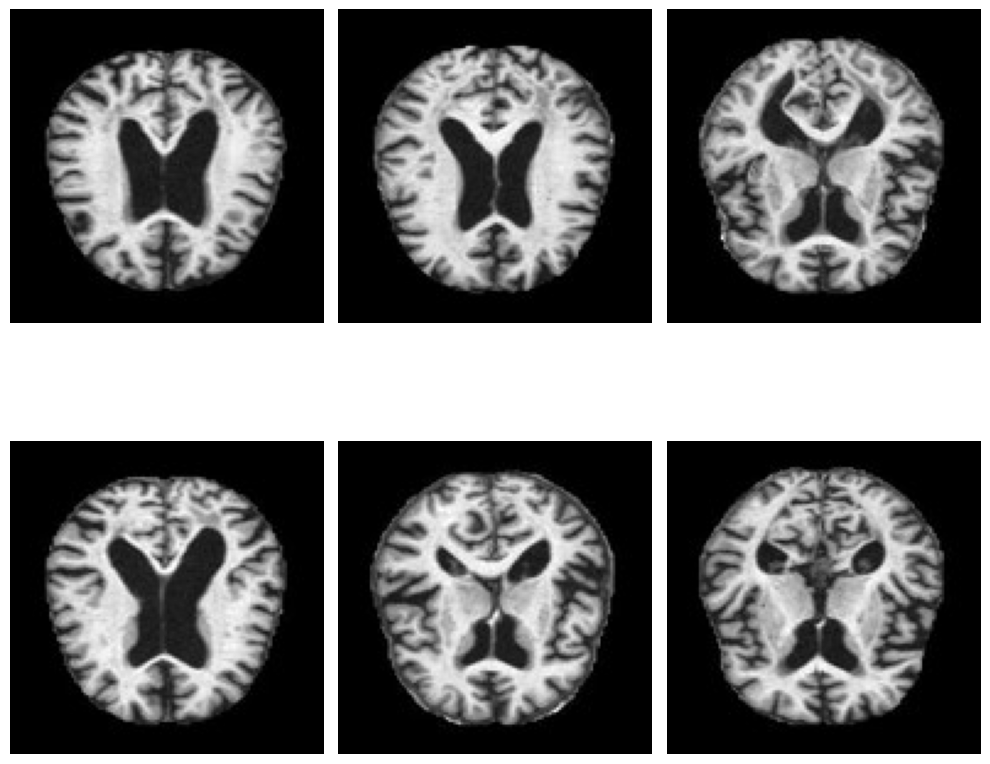

In [14]:
display_df(imgs)

### add noise

In [15]:
noise_factor = 0.25

noise_imgs = []

for img in imgs :
  imNoise = img +noise_factor * np.random.randn(*img.shape)
  imNoise =np.clip(imNoise ,0.0,1.0)
  noise_imgs.append(imNoise)


In [16]:
noise_imgs = np.array(noise_imgs)

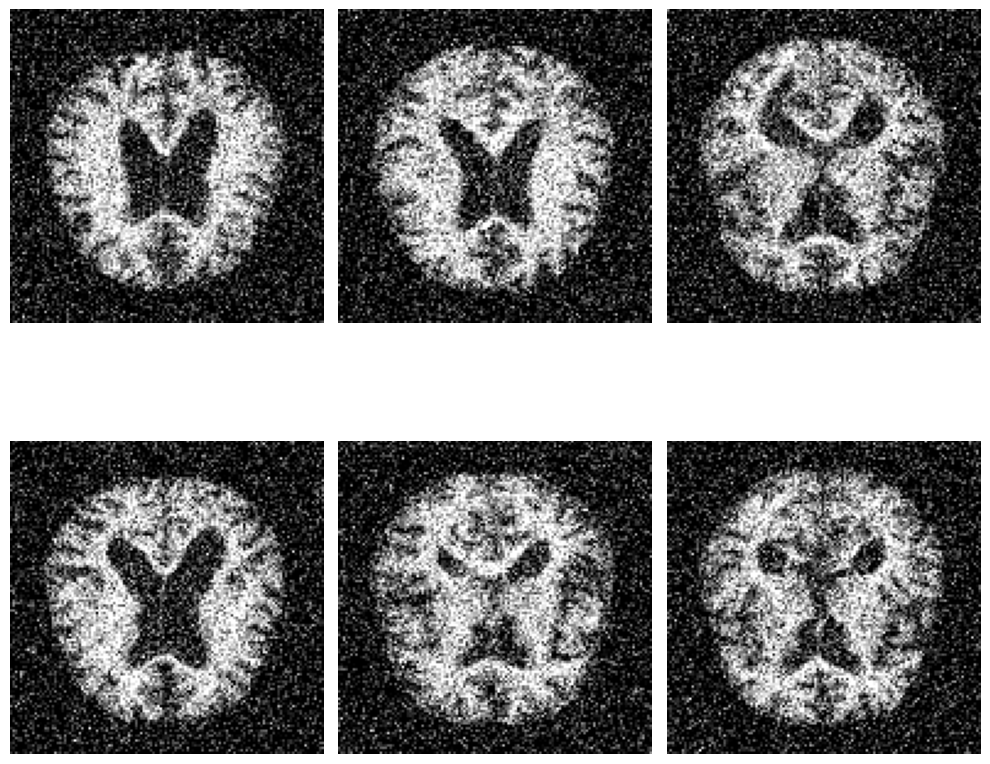

In [17]:
display_df(noise_imgs)

### split data

In [18]:
# normal

normal_train = imgs[:696]
normal_valid = imgs[696:796]
normal_test = imgs[796:896]

# noisy
noisy_train = noise_imgs[:696]
noisy_valid = noise_imgs[696:796]
noisy_test = noise_imgs[796:896]

In [19]:
normal_train.shape , normal_test.shape , normal_valid.shape

((696, 128, 128, 1), (100, 128, 128, 1), (100, 128, 128, 1))

In [20]:
noisy_train.shape , noisy_test.shape , noisy_valid.shape


((696, 128, 128, 1), (100, 128, 128, 1), (100, 128, 128, 1))

### Model

In [97]:
# autoEncoder

# encoder

input_layer = Input(shape=(128,128,1), name= ' input_layer' )
#
Conv_layer1_en = Conv2D(128, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_1')(input_layer)
Conv_layer1_en = MaxPooling2D((2,2),padding='same' ,name ='Conv1_pool')(Conv_layer1_en)
#
Conv_layer2_en = Conv2D(64, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_2')(Conv_layer1_en)
Conv_layer2_en = MaxPooling2D((2,2),padding='same',name ='Conv2_pool')(Conv_layer2_en)
#
Conv_layer3_en = Conv2D(32, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_3')(Conv_layer2_en)
Conv_layer3_en = MaxPooling2D((2,2),padding='same',name ='Conv3_pool')(Conv_layer3_en)


# decoder
Conv_layer4_de = Conv2D(32, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_4')(Conv_layer3_en)
Conv_layer4_de = UpSampling2D((2,2),name ='Conv4_Up')(Conv_layer4_de)
#
Conv_layer5_de = Conv2D(64, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_5')(Conv_layer4_de)
Conv_layer5_de = UpSampling2D((2,2),name ='Conv5_Up')(Conv_layer5_de)
#
Conv_layer6_de = Conv2D(128, (3,3), activation ='relu' , padding = 'same' ,name = 'Conv_6')(Conv_layer5_de)
Conv_layer6_de = UpSampling2D((2,2),name ='Conv6_Up')(Conv_layer6_de)
#
output_layer = Conv2D(1 ,(3,3), activation= 'sigmoid',padding = 'same' ,name = 'output_layer')(Conv_layer6_de)




In [98]:
model = Model(inputs =input_layer ,outputs = output_layer)

In [99]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
  input_layer (InputLayer)   [(None, 128, 128, 1)]     0         
                                                                 
 Conv_1 (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 Conv1_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
                                                                 
 Conv_2 (Conv2D)             (None, 64, 64, 64)        73792     
                                                                 
 Conv2_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 32, 32, 32)        18464     
                                                                 
 Conv3_pool (MaxPooling2D)   (None, 16, 16, 32)        0   

In [100]:
optimizer = Adam(learning_rate=0.00053)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

In [101]:
history=model.fit (noisy_train ,normal_train , validation_data=(noisy_valid ,normal_valid) , epochs =500,
          batch_size=64, validation_batch_size = 32 )

Epoch 1/500
11/11 [==============================] - 4s 174ms/step - loss: 0.6616 - val_loss: 0.6078
Epoch 2/500
11/11 [==============================] - 2s 156ms/step - loss: 0.5015 - val_loss: 0.3773
Epoch 3/500
11/11 [==============================] - 2s 158ms/step - loss: 0.3553 - val_loss: 0.3466
Epoch 4/500
11/11 [==============================] - 2s 159ms/step - loss: 0.3481 - val_loss: 0.3473
Epoch 5/500
11/11 [==============================] - 2s 154ms/step - loss: 0.3454 - val_loss: 0.3419
Epoch 6/500
11/11 [==============================] - 2s 159ms/step - loss: 0.3394 - val_loss: 0.3341
Epoch 7/500
11/11 [==============================] - 2s 156ms/step - loss: 0.3312 - val_loss: 0.3296
Epoch 8/500
11/11 [==============================] - 2s 156ms/step - loss: 0.3275 - val_loss: 0.3215
Epoch 9/500
11/11 [==============================] - 2s 158ms/step - loss: 0.3226 - val_loss: 0.3206
Epoch 10/500
11/11 [==============================] - 2s 150ms/step - loss: 0.3208 - val_lo

<Axes: >

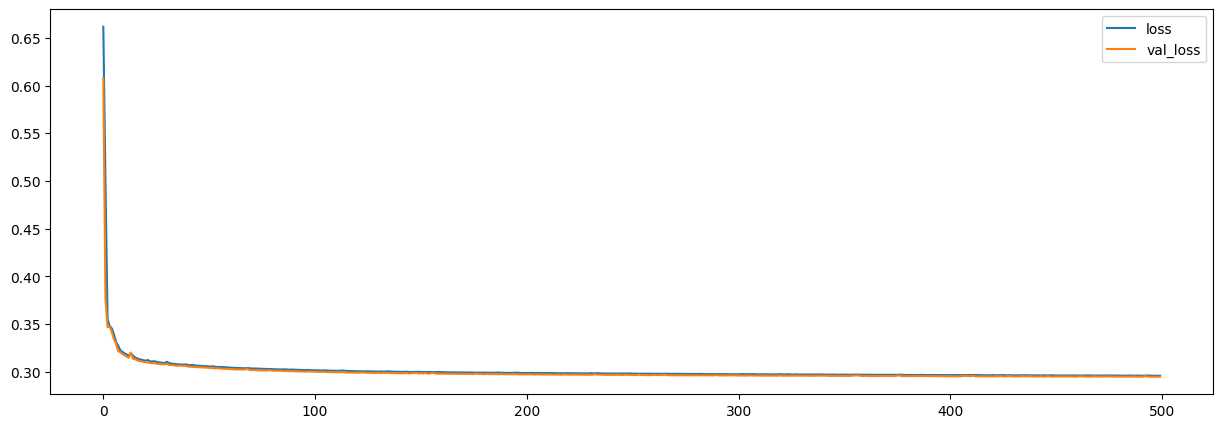

In [102]:
pd.DataFrame(history.history).plot(figsize=(15, 5))


## Evaluation

In [103]:
pred_imgs = model.predict(noisy_test)

4/4 [==============================] - 0s 30ms/step


In [104]:
evl = model.evaluate(noisy_test, normal_test)
evl

4/4 [==============================] - 0s 25ms/step - loss: 0.2975


0.29748427867889404

In [105]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(normal_test.flatten(),pred_imgs.flatten())

mse

0.005705012

In [107]:
from skimage.metrics import peak_signal_noise_ratio

psnr = [ abs(peak_signal_noise_ratio(clean_img , denoised_img ,
                                       data_range=denoised_img.max() - denoised_img.min())) for clean_img ,denoised_img in zip(normal_test ,pred_imgs)]
avg_psnr = np.mean(psnr)
avg_psnr


21.88973206475409

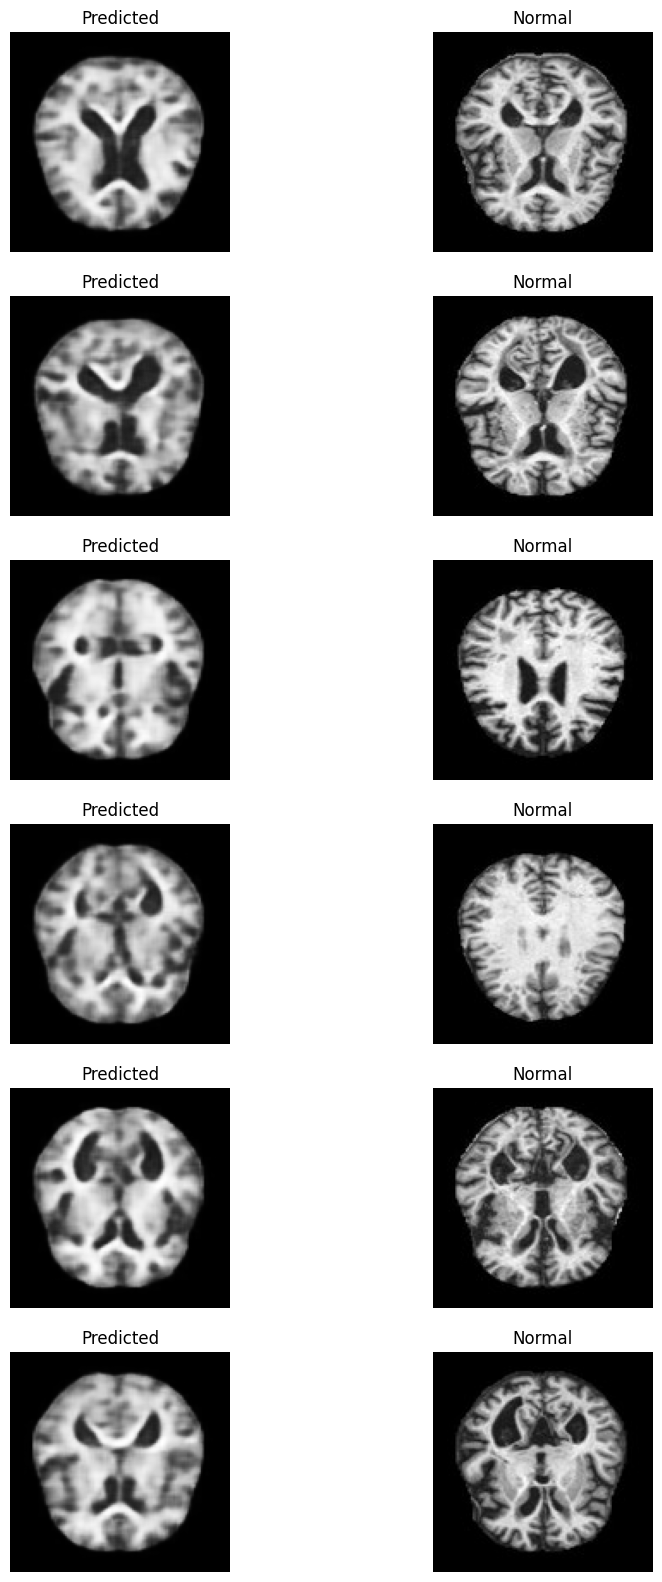

In [106]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()

for i  in range(12):

  if i % 2 !=0 :
    axs[i].imshow(normal_test[i], cmap='gray')
    axs[i].set_title('Normal')
    # print()
  else :
    axs[i].imshow(pred_imgs[i], cmap='gray')
    axs[i].set_title('Predicted')
    # print()


  axs[i].axis('off')
  axs[i].axis('off')

plt.show()